# Compare Contrail Signature Between GOES-West vs GOES-East
---

**Hypothesis:** Clouds such as contrails should have a larger signal-to-noise ratio in GOES-West in the morning and GOES-East in the evening due to Mie scattering.


In [1]:
import os
if os.getcwd() == '/content':
    print("You are working in a Google colab notebook!\nLet's grab data and code from github.\n")
    !rm -r Get_GOES scripts figures data
    !git clone https://github.com/reykoki/Get_GOES.git
    !rm Get_GOES/Get_GOES.ipynb
    !mv Get_GOES/* .
    !pip install -r requirements.txt
import matplotlib.pyplot as plt
import numpy as np
import skimage
from glob import glob
from datetime import datetime
import pytz
import pyproj
import sys
sys.path.insert(1, './scripts')
from helper_functions import *
from satpy.writers import get_enhanced_image
import cartopy.crs as ccrs
from satpy import Scene
from pyresample import create_area_def
from grab_goes import download_goes # ./scripts/grab_goes.py
from plot_tifs import * # ./scripts/plot_tifs.py


In [2]:
def normalize(data):
    return (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))


def get_proj():
    lcc_proj = ccrs.LambertConformal(central_longitude=262.5,
                                     central_latitude=38.5,
                                     standard_parallels=(38.5, 38.5),
                                     globe=ccrs.Globe(semimajor_axis=6371229,
                                                      semiminor_axis=6371229))
    return lcc_proj


# get the Satpy Scene object
def get_scn(fns, to_load, extent, res=3000, proj=get_proj(), reader='abi_l1b', print_info=False):
    scn = Scene(reader=reader, filenames=fns)  
    scn.load(to_load, generate=False)
    my_area = create_area_def(area_id='my_area',
                              projection=proj,
                              resolution=res,
                              area_extent=extent
                              )
    if print_info:
        print("Available channels in the Scene object:\n", scn.available_dataset_names())
        print("\nAvailable composites:\n", scn.available_composite_names())
        print("\nArea definitition:\n",my_area)    
    new_scn = scn.resample(my_area) # resamples datasets and resturns a new scene object
    return new_scn

def get_RGB(scn, composite):
    RGB = get_enhanced_image(scn[composite]).data.compute().data
    RGB = np.einsum('ijk->jki', RGB)
    RGB[np.isnan(RGB)] = 0
    RGB[:,:,0] = normalize(RGB[:,:,0])
    RGB[:,:,1] = normalize(RGB[:,:,1])
    RGB[:,:,2] = normalize(RGB[:,:,2])

    return RGB

def save_data(data, band, fn_head):
    tif_fn_data = data_dir + 'data/{}_{}.tif'.format(band, fn_head)
    skimage.io.imsave(tif_fn_data, data)
    print("saved file: {}".format(tif_fn_data))

def save_coords(lat, lon, fn_head):
    tif_fn_coords = data_dir + 'coords/{}.tif'.format(fn_head)
    coords_layers = np.dstack([lat, lon])
    skimage.io.imsave(tif_fn_coords, coords_layers)
    print("saved file: {}".format(tif_fn_coords))

def get_extent(lat, lon, res, img_size=64): # img_size - number of pixels
    lcc_proj = pyproj.Proj(get_proj())
    center = lcc_proj(lon,lat)
    dist = int(img_size/2*res)
    x0 = center[0] - dist
    y0 = center[1] - dist
    x1 = center[0] + dist
    y1 = center[1] + dist
    return [x0, y0, x1, y1]

def create_raw(sat_fns, lat, lon, res=2000): # res is resolution in km
    fn_head = 'G' + sat_fns[0].split('_G')[-1].split('_c')[0]+'_'+lat+'_'+lon
    extent = get_extent(lat, lon, res)
    bands = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16']
    scn = get_scn(sat_fns, bands, extent, res)
    lons, lats = scn[bands[0]].attrs['area'].get_lonlats()
    for band in bands:
        save_data(scn[band].data, band, fn_head)
    save_coords(lats, lons, fn_head)
    return fn_head, scn
def create_composite(sat_fns, lat, lon, composites = ['cimss_true_color_sunz_rayleigh', 'airmass'], res=2000):
    fn_head = 'G' + sat_fns[0].split('_G')[-1].split('_c')[0]+'_'+lat+'_'+lon
    extent = get_extent(lat, lon, res)
    scn = get_scn(sat_fns, composites, extent, res)
    lons, lats = scn[composites[0]].attrs['area'].get_lonlats()
    for composite in composites:
        data = get_RGB(scn, composite)
        
        save_data(data, composite, fn_head)
    save_coords(lats, lons, fn_head)
    return fn_head, scn   

def plot_composite(composite, fn_head, data_loc="./data/"):
    data_fn = glob("{}data/{}_{}*.tif".format(data_loc, composite, fn_head))[0]
    coords_fn = glob("{}coords/{}.tif".format(data_loc, fn_head))[0]
    print(get_datetime_from_fn(coords_fn))
    RGB = skimage.io.imread(data_fn, plugin='tifffile')
    lat, lon = get_lat_lon(coords_fn)
    plt.figure(figsize=(8, 6),dpi=100)
    plt.imshow(RGB)
    plt.yticks(np.linspace(0,RGB.shape[0]-1,len(lat)), np.round(lat,2), fontsize=12)
    plt.ylabel('latitude (degrees)', fontsize=16)
    plt.xticks(np.linspace(0,RGB.shape[0]-1,len(lon)), np.round(lon,2), fontsize=12)
    plt.xlabel('longitude (degrees)', fontsize=16)
    #plt.title(composite,fontsize=24)
    plt.title('GOES-East',fontsize=24)
    plt.tight_layout(pad=0)
    plt.show()

def plot_composite_W_E(composite, fn_head_W, fn_head_E, data_loc="./data/"):
    data_fn_W = glob("{}data/{}_{}*.tif".format(data_loc, composite, fn_head_W))[0]
    data_fn_E = glob("{}data/{}_{}*.tif".format(data_loc, composite, fn_head_E))[0]
    coords_fn = glob("{}coords/{}.tif".format(data_loc, fn_head_W))[0]
    print(get_datetime_from_fn(coords_fn))
    RGB_W = skimage.io.imread(data_fn_W, plugin='tifffile')
    RGB_E = skimage.io.imread(data_fn_E, plugin='tifffile')
    lat, lon = get_lat_lon(coords_fn)
    fig, ax = plt.subplots(1, 2, figsize=(15,30),dpi=300)
    ax[0].imshow(RGB_W)
    ax[1].imshow(RGB_E)
    ax[0].set_yticks(np.linspace(0, RGB_W.shape[0]-1,len(lat)), np.round(lat,2), fontsize=12)
    ax[0].set_ylabel('latitude (degrees)', fontsize=20)
    ax[0].set_xticks(np.linspace(0,RGB_E.shape[0]-1,len(lon)), np.round(lon,2), fontsize=12)
    ax[0].set_xlabel('longitude (degrees)', fontsize=20)
    #plt.title(composite,fontsize=24)
    ax[0].set_title('GOES-West',fontsize=24)
    ax[1].set_title('GOES-East',fontsize=24)
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    plt.tight_layout(pad=0)
    plt.show()


In [3]:
def composite_GOES(lat, lon, dt_str, sat_num):
    dt = pytz.utc.localize(datetime.strptime(dt_str, '%Y/%m/%d %H:%M')) # convert to datetime object
    
    sat_fns = download_goes(dt, scope='F', sat_num=sat_num, bands = [2,4,5])
    #fn_head, scn = create_raw(sat_fns, lat, lon, res=2000)
    #plot_all_bands(fn_head)
    #composites = ['colorized_ir_clouds', 'cimss_cloud_type', 'airmass','cimss_true_color_sunz_rayleigh']
    composites = ['cimss_cloud_type']
    fn_head, scn = create_composite(sat_fns, lat, lon, composites)

    return fn_head, composites
def composite_GOES_W_E(lat, lon, dt_str):
    dt = pytz.utc.localize(datetime.strptime(dt_str, '%Y-%m-%dT%H:%M')) # convert to datetime object
    sat_fns_E = download_goes(dt, scope='F', sat_num='16', bands = [2,4,5])
    sat_fns_W = download_goes(dt, scope='F', sat_num='18', bands = [2,4,5])
    #fn_head, scn = create_raw(sat_fns, lat, lon, res=2000)
    #plot_all_bands(fn_head)
    #composites = ['colorized_ir_clouds', 'cimss_cloud_type', 'airmass','cimss_true_color_sunz_rayleigh']
    composites = ['cimss_cloud_type']
    fn_head_W, scn = create_composite(sat_fns_W, lat, lon, composites)
    fn_head_E, scn = create_composite(sat_fns_E, lat, lon, composites)
    return fn_head_W, fn_head_E, composites


In [5]:

dt_str = '2025/02/24 17:30'
dt_str = '2025-02-28T15:20'

lon = '-119.1'
lat = '38.9'
#fn_head, composites = composite_GOES(lat, lon, dt_str, '16')
fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt_str)


for the datetime 2025-02-28 15:20:00+00:00:
sunrise is at: 2025-02-28 14:42:36+00:00
sunset is at: 2025-02-28 22:28:48+00:00
downloading OR_ABI-L1b-RadF-M6C02_G16_s20250591520210_e20250591529518_c20250591529553.nc
downloading OR_ABI-L1b-RadF-M6C04_G16_s20250591520210_e20250591529518_c20250591529536.nc
downloading OR_ABI-L1b-RadF-M6C05_G16_s20250591520210_e20250591529518_c20250591529559.nc
for the datetime 2025-02-28 15:20:00+00:00:
sunrise is at: 2025-02-28 14:42:36+00:00
sunset is at: 2025-02-28 22:28:48+00:00
downloading OR_ABI-L1b-RadF-M6C02_G18_s20250591520222_e20250591529530_c20250591529557.nc
downloading OR_ABI-L1b-RadF-M6C04_G18_s20250591520222_e20250591529530_c20250591529562.nc
downloading OR_ABI-L1b-RadF-M6C05_G18_s20250591520222_e20250591529530_c20250591529568.nc
saved file: ./data/data/cimss_cloud_type_G18_s20250591520222_e20250591529530_38.9_-119.1.tif
saved file: ./data/coords/G18_s20250591520222_e20250591529530_38.9_-119.1.tif
saved file: ./data/data/cimss_cloud_type_G16_

2025/02/28 15:20 UTC


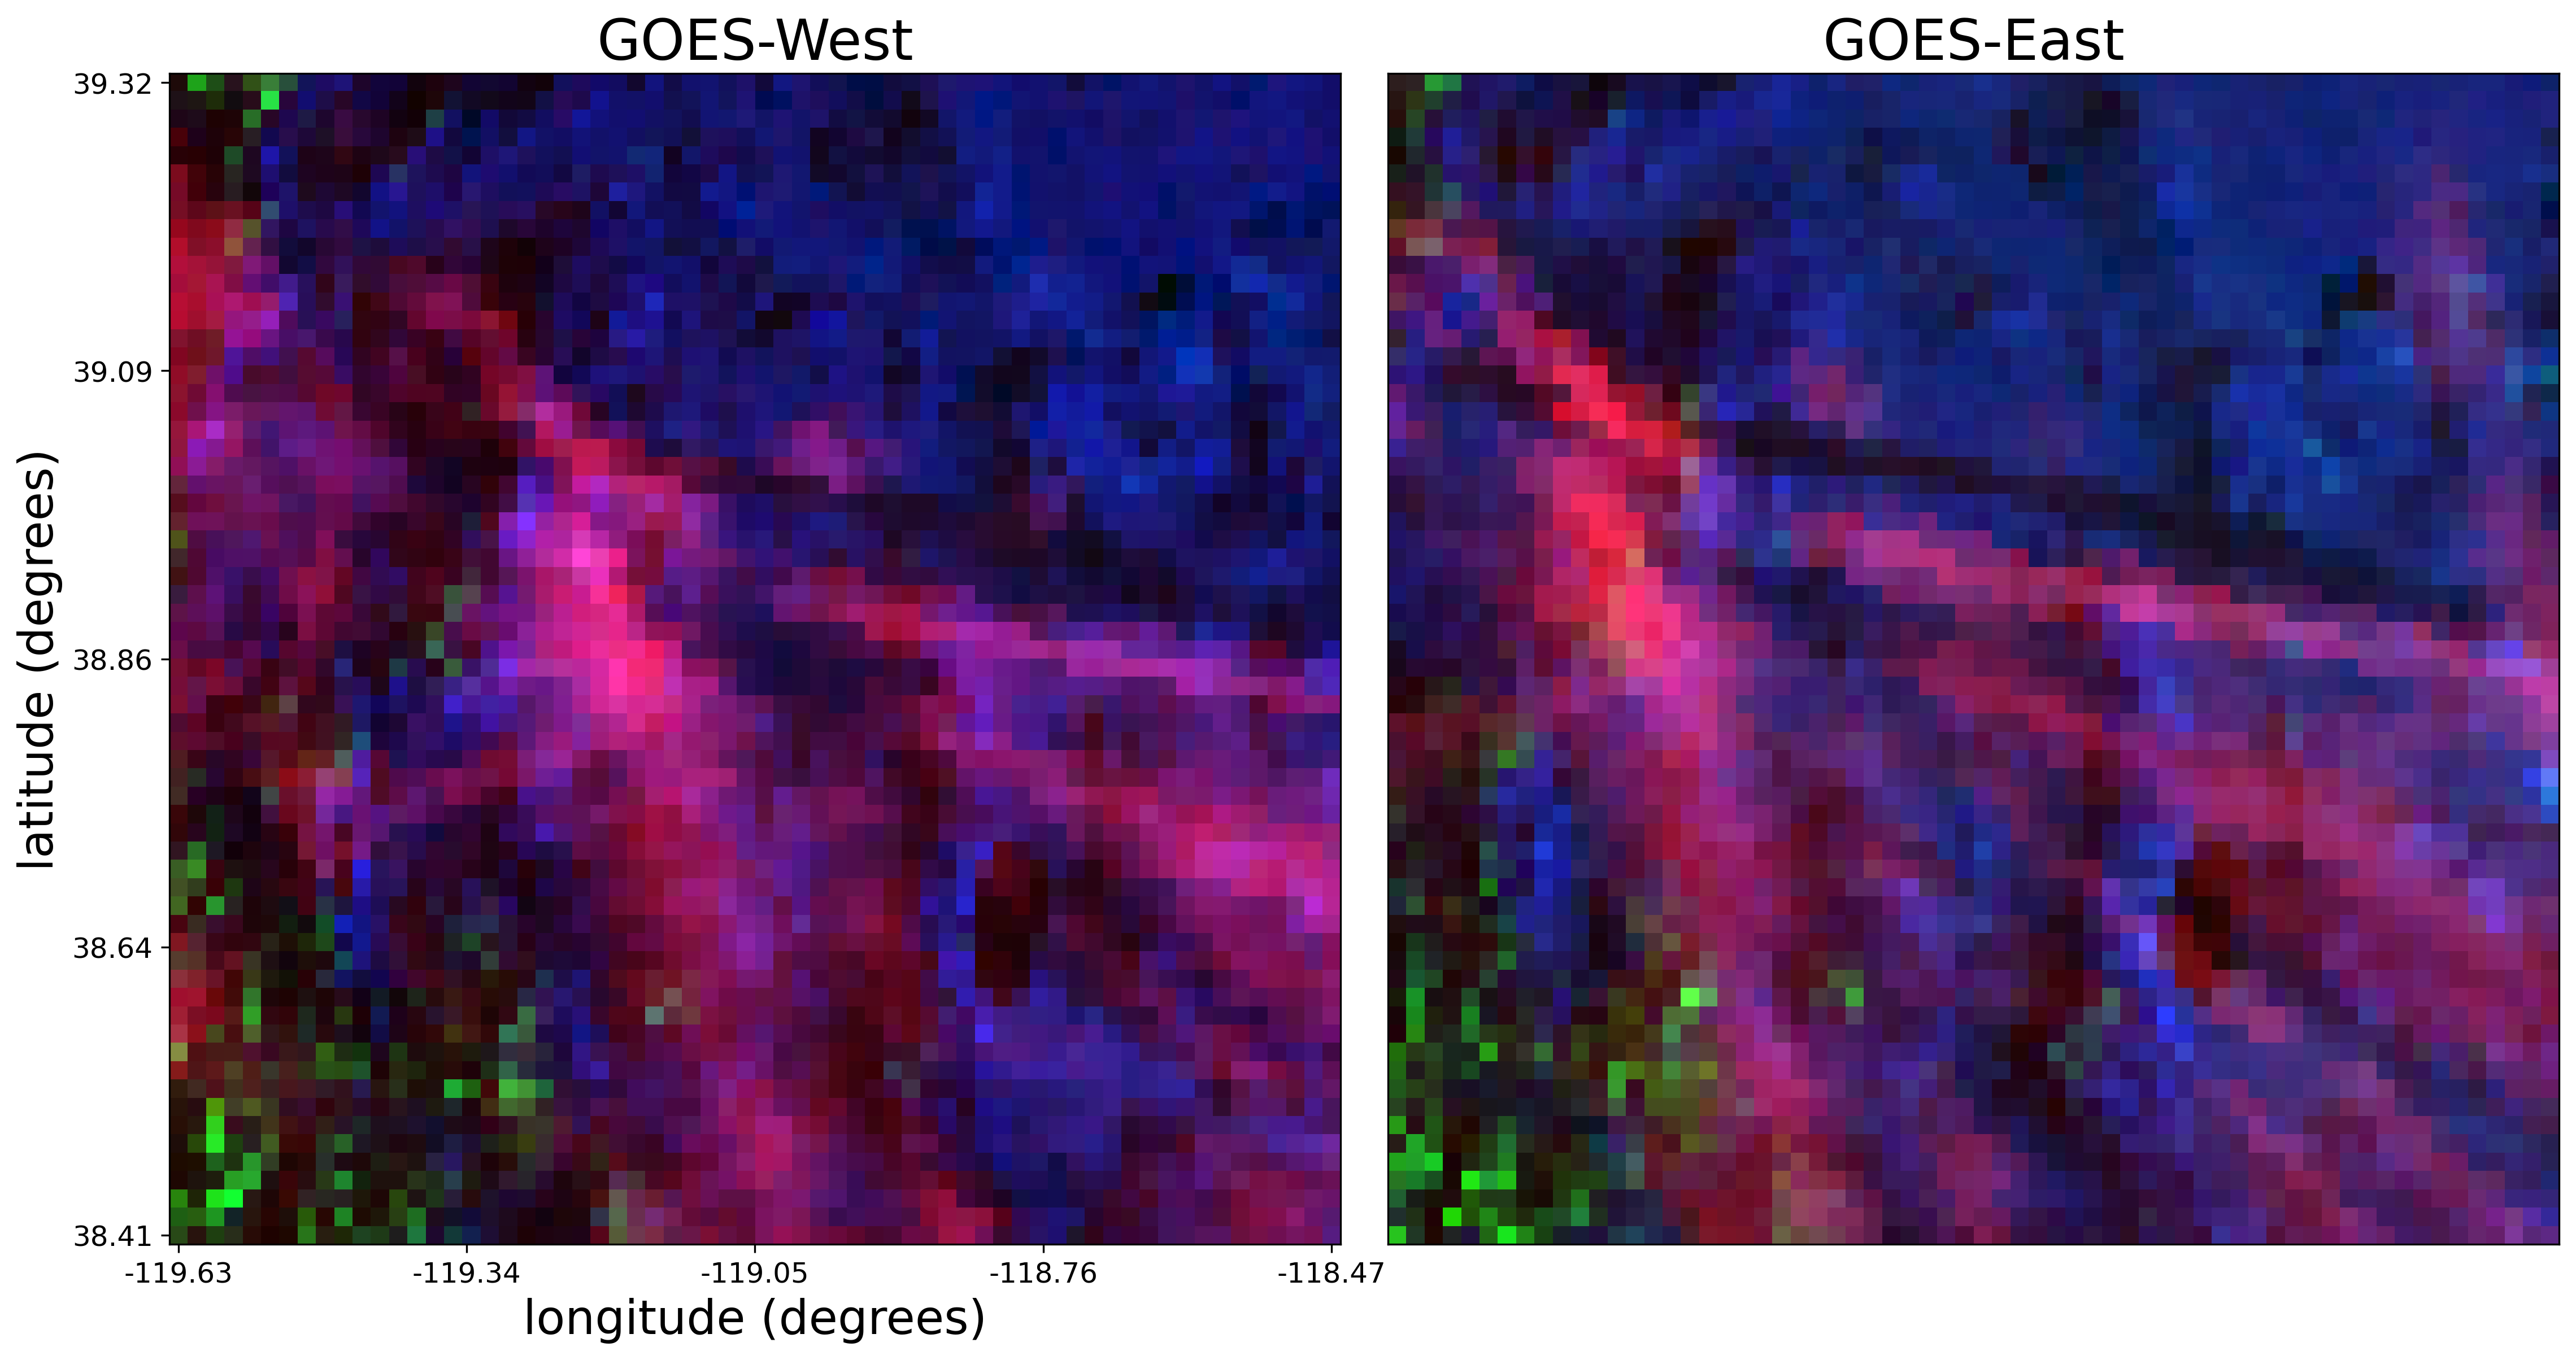

In [6]:
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

for the datetime 2025-02-24 17:30:00+00:00:
sunrise is at: 2025-02-24 14:46:12+00:00
sunset is at: 2025-02-24 22:23:24+00:00
OR_ABI-L1b-RadF-M6C02_G16_s20250551730206_e20250551739514_c20250551739549.nc already exists
OR_ABI-L1b-RadF-M6C04_G16_s20250551730206_e20250551739514_c20250551739533.nc already exists
OR_ABI-L1b-RadF-M6C05_G16_s20250551730206_e20250551739514_c20250551739570.nc already exists
for the datetime 2025-02-24 17:30:00+00:00:
sunrise is at: 2025-02-24 14:46:12+00:00
sunset is at: 2025-02-24 22:23:24+00:00
OR_ABI-L1b-RadF-M6C02_G18_s20250551730216_e20250551739524_c20250551739549.nc already exists
OR_ABI-L1b-RadF-M6C04_G18_s20250551730216_e20250551739524_c20250551739553.nc already exists
OR_ABI-L1b-RadF-M6C05_G18_s20250551730216_e20250551739524_c20250551739560.nc already exists
saved file: ./data/data/cimss_cloud_type_G18_s20250551730216_e20250551739524_35.26_-97.43.tif
saved file: ./data/coords/G18_s20250551730216_e20250551739524_35.26_-97.43.tif
saved file: ./data/data/c

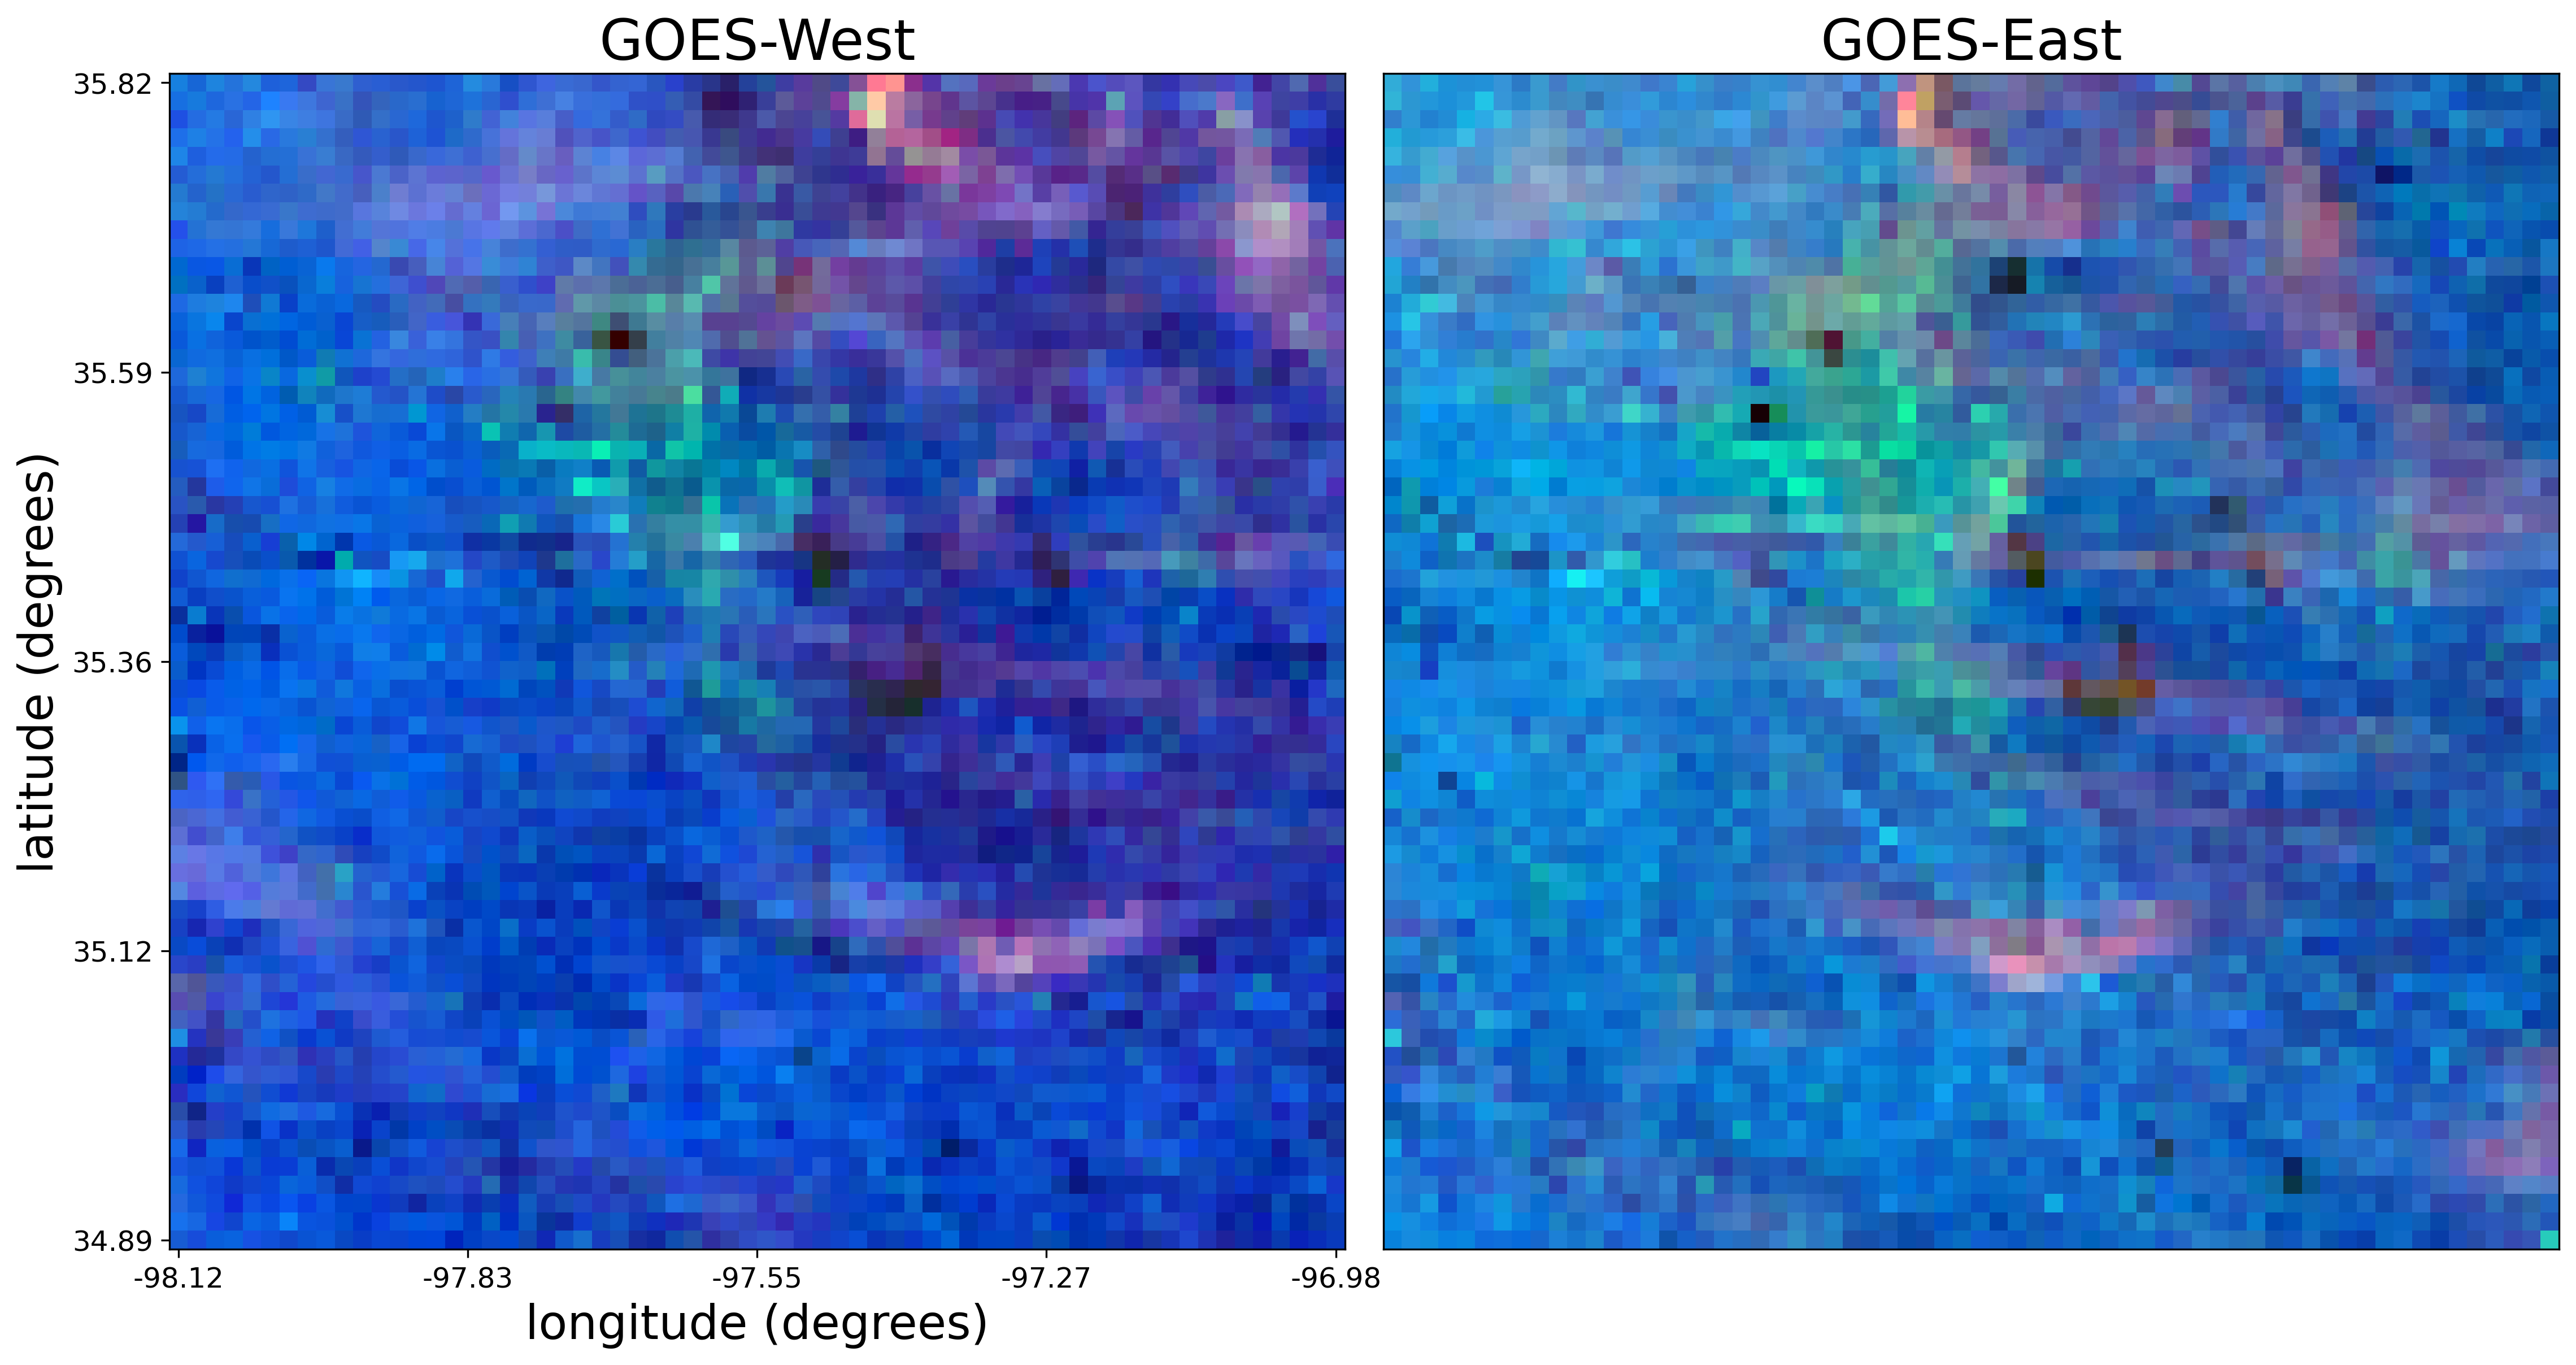

In [151]:
fn_head_W, fn_head_E, composites = composite_GOES_W_E('35.26', '-97.43', '2025-02-24T17:30')
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

for the datetime 2025-02-24 22:39:00+00:00:
sunrise is at: 2025-02-24 14:46:12+00:00
sunset is at: 2025-02-24 22:23:24+00:00
OR_ABI-L1b-RadF-M6C02_G16_s20250552240206_e20250552249514_c20250552249544.nc already exists
OR_ABI-L1b-RadF-M6C04_G16_s20250552240206_e20250552249514_c20250552249531.nc already exists
OR_ABI-L1b-RadF-M6C05_G16_s20250552240206_e20250552249514_c20250552249560.nc already exists
for the datetime 2025-02-24 22:39:00+00:00:
sunrise is at: 2025-02-24 14:46:12+00:00
sunset is at: 2025-02-24 22:23:24+00:00
OR_ABI-L1b-RadF-M6C02_G18_s20250552240214_e20250552249522_c20250552249554.nc already exists
OR_ABI-L1b-RadF-M6C04_G18_s20250552240214_e20250552249522_c20250552249561.nc already exists
OR_ABI-L1b-RadF-M6C05_G18_s20250552240214_e20250552249522_c20250552249571.nc already exists
saved file: ./data/data/cimss_cloud_type_G18_s20250552240214_e20250552249522_35.56_-119.74.tif
saved file: ./data/coords/G18_s20250552240214_e20250552249522_35.56_-119.74.tif
saved file: ./data/data

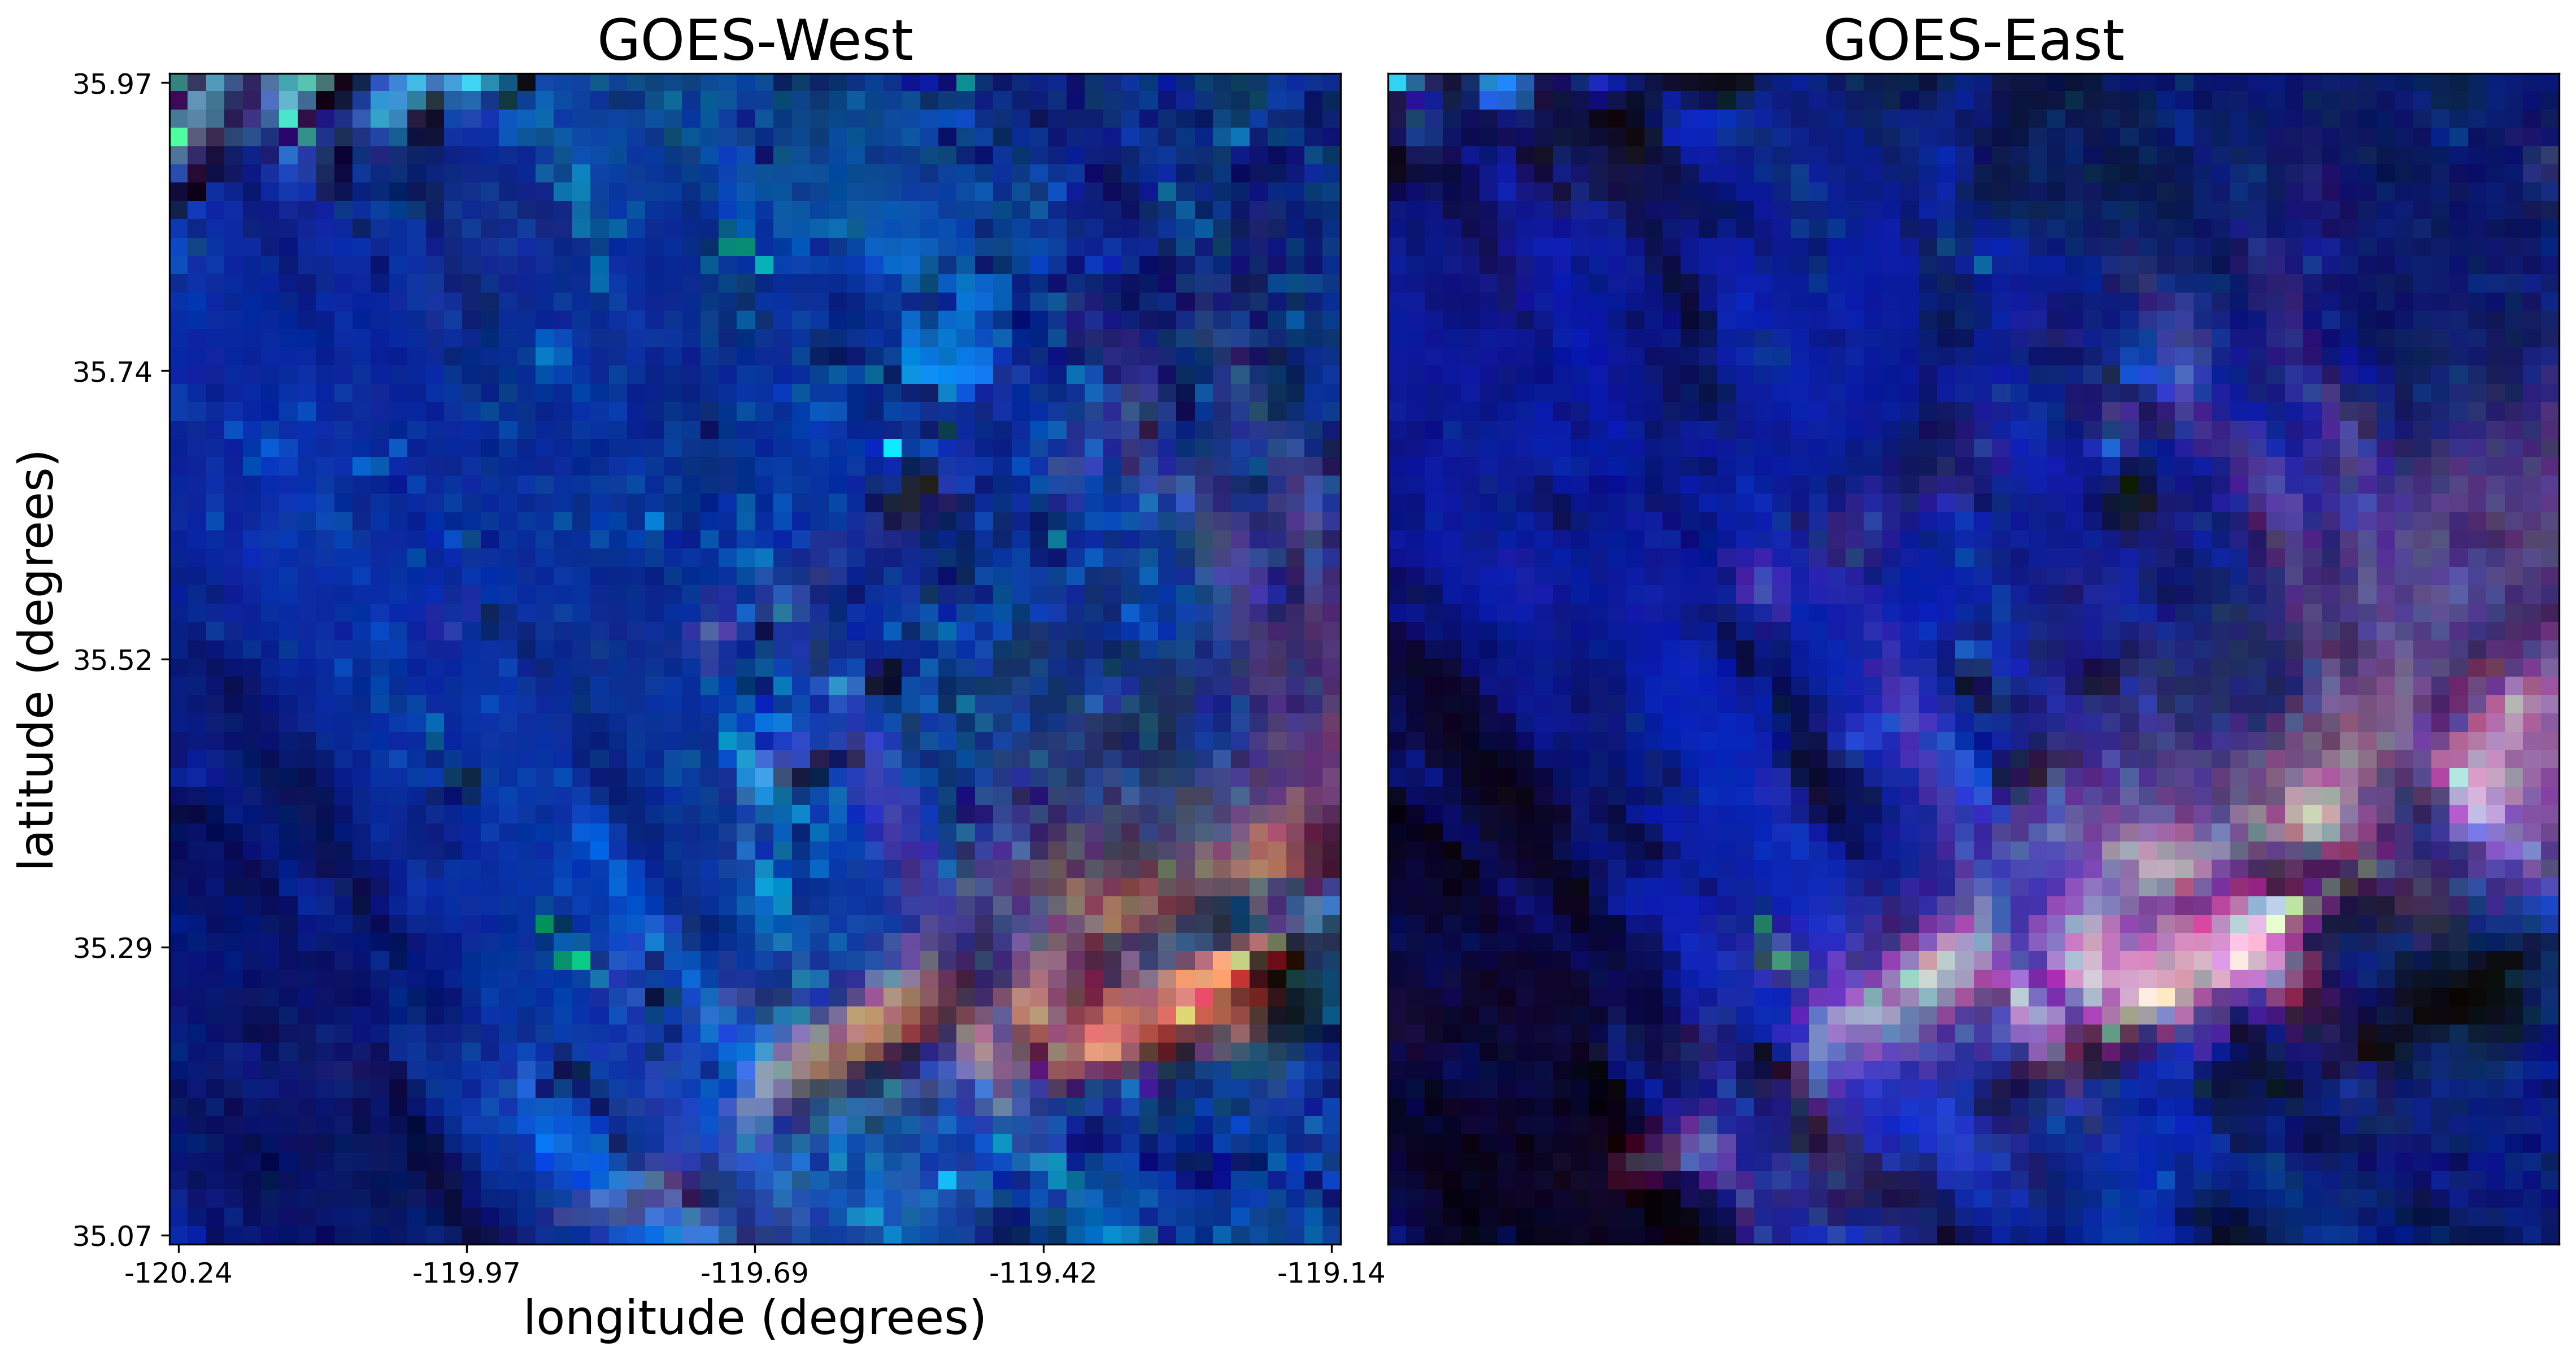

In [152]:
dt_str = '2025-02-24T22:39'
lat = '35.56'
lon = '-119.74'

fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt_str)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

for the datetime 2025-02-24 22:41:00+00:00:
sunrise is at: 2025-02-24 14:46:12+00:00
sunset is at: 2025-02-24 22:23:24+00:00
OR_ABI-L1b-RadF-M6C02_G16_s20250552240206_e20250552249514_c20250552249544.nc already exists
OR_ABI-L1b-RadF-M6C04_G16_s20250552240206_e20250552249514_c20250552249531.nc already exists
OR_ABI-L1b-RadF-M6C05_G16_s20250552240206_e20250552249514_c20250552249560.nc already exists
for the datetime 2025-02-24 22:41:00+00:00:
sunrise is at: 2025-02-24 14:46:12+00:00
sunset is at: 2025-02-24 22:23:24+00:00
OR_ABI-L1b-RadF-M6C02_G18_s20250552240214_e20250552249522_c20250552249554.nc already exists
OR_ABI-L1b-RadF-M6C04_G18_s20250552240214_e20250552249522_c20250552249561.nc already exists
OR_ABI-L1b-RadF-M6C05_G18_s20250552240214_e20250552249522_c20250552249571.nc already exists
saved file: ./data/data/cimss_cloud_type_G18_s20250552240214_e20250552249522_27.71_-81.340.tif
saved file: ./data/coords/G18_s20250552240214_e20250552249522_27.71_-81.340.tif
saved file: ./data/data

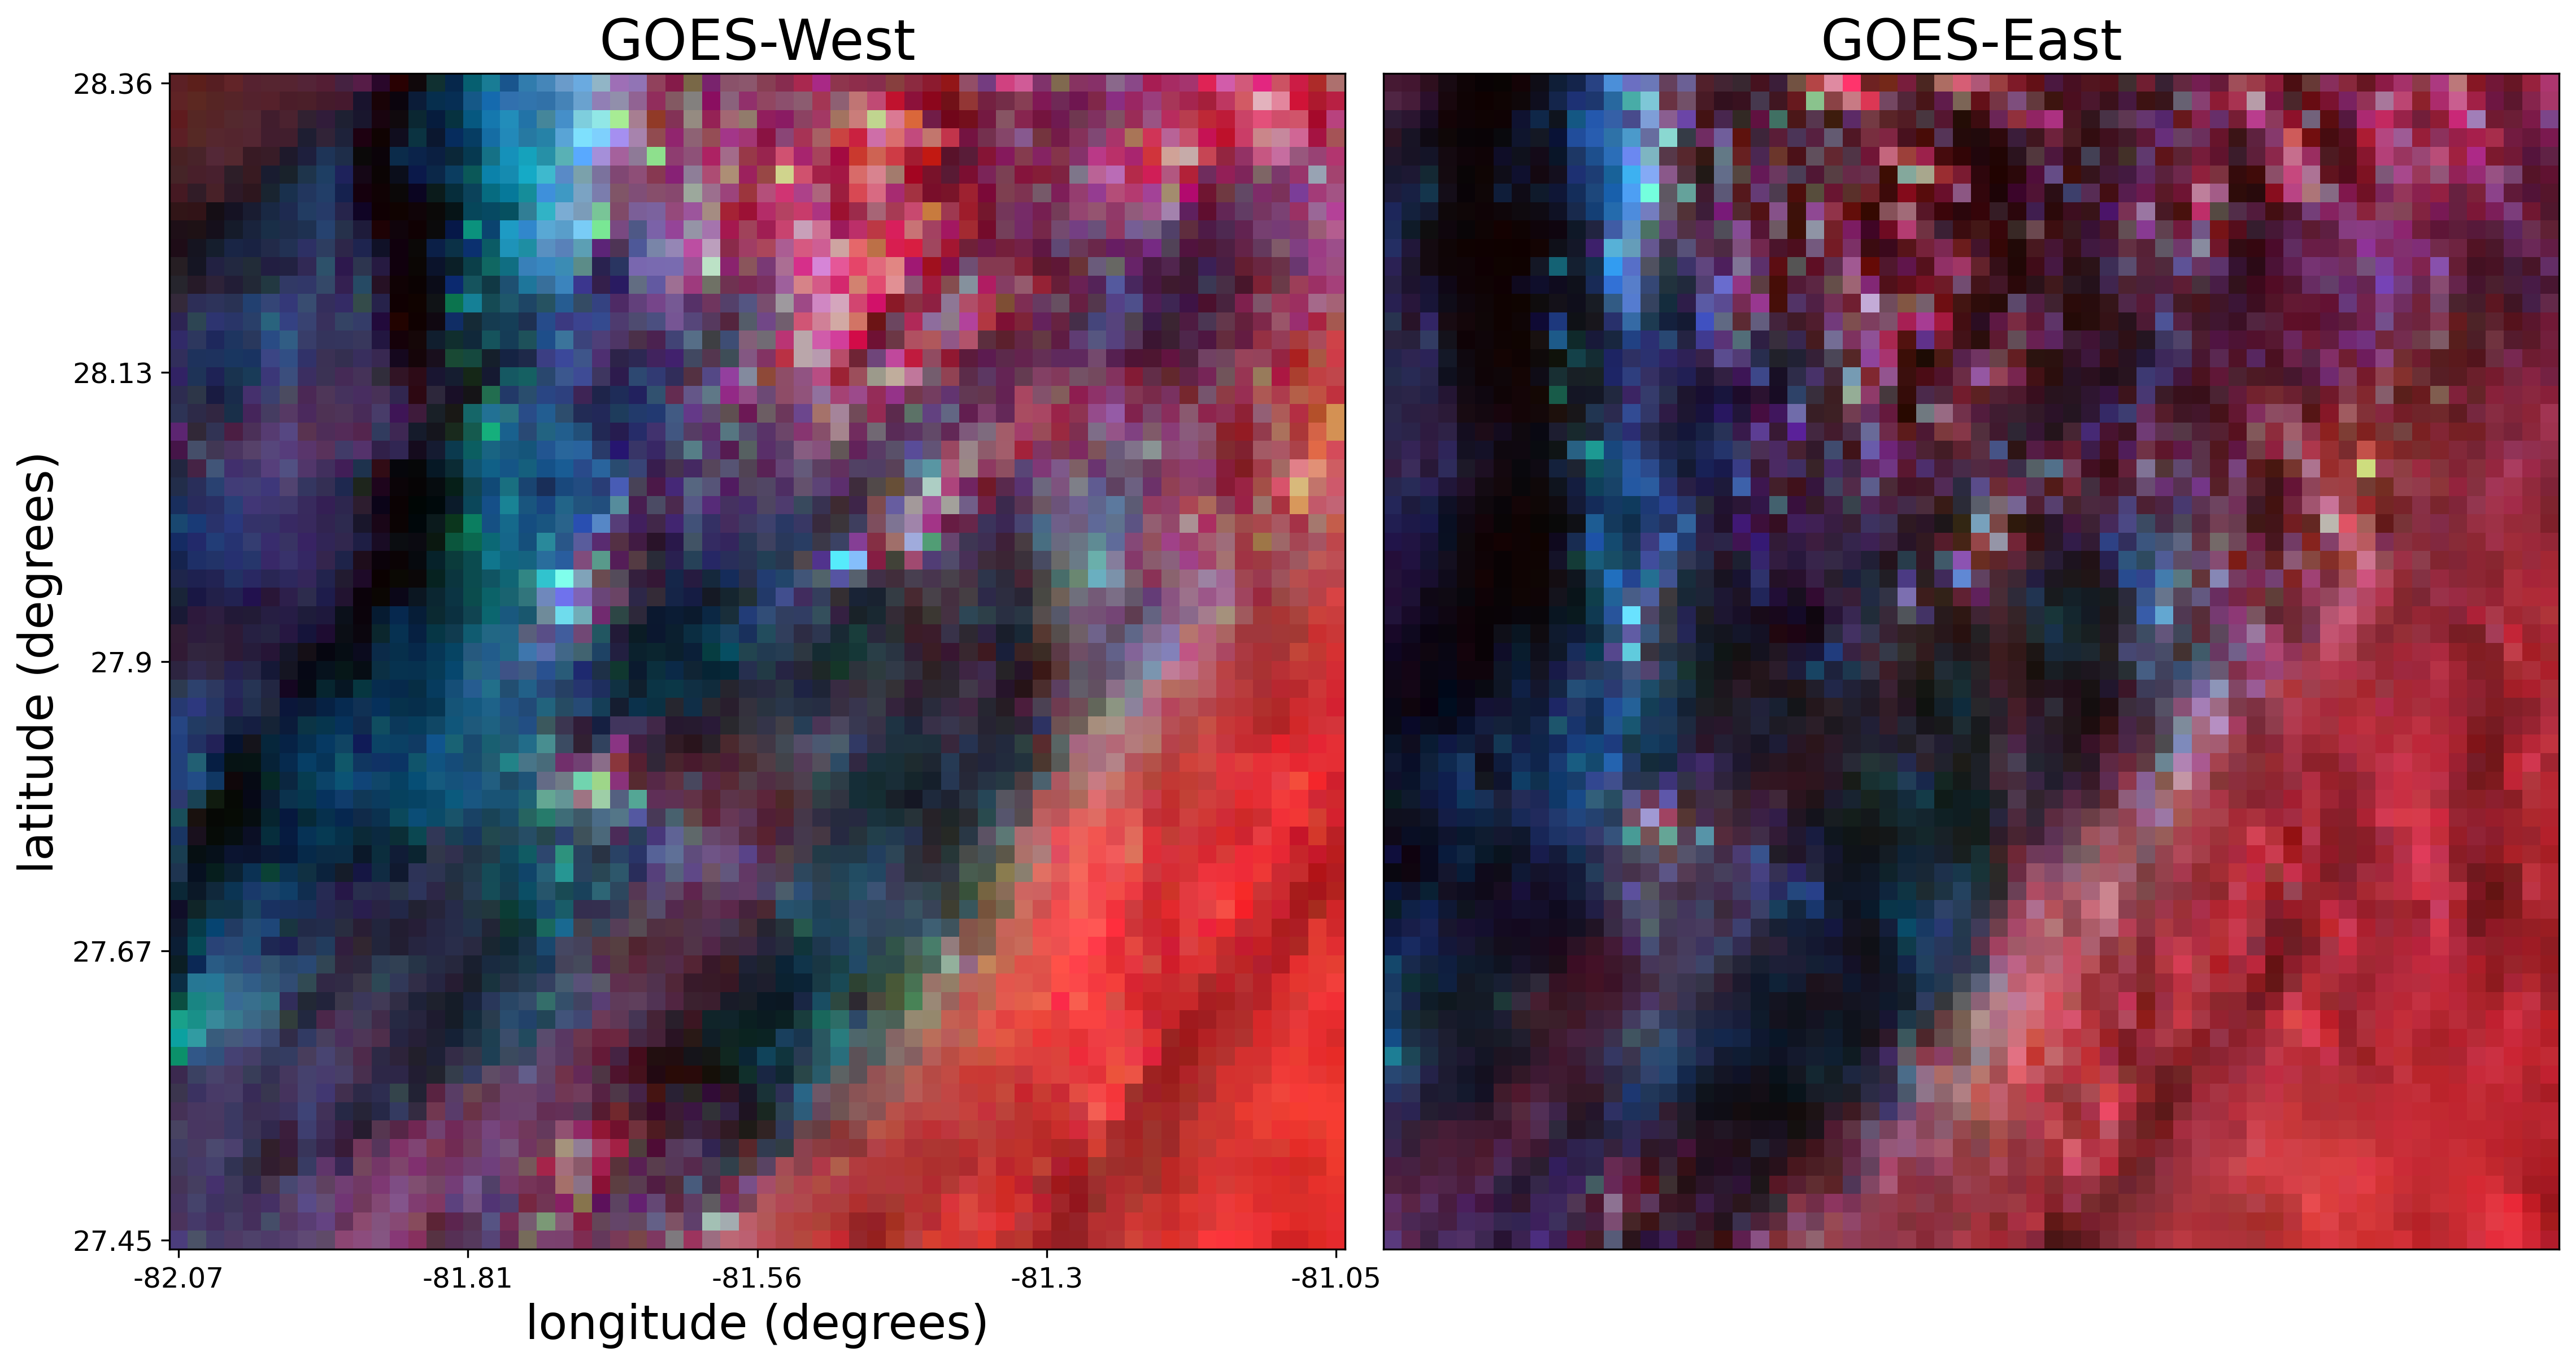

In [153]:
#https://contrails.webapps.google.com/main?latitude=27.720&longitude=-81.620&zoom=50.00&imagetype=cirrus&time=1740436390
dt_str = '2025-02-24T22:41'
lat = '27.71'
lon = '-81.340'

fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt_str)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

gulf of mexico, off west coast of florida

closer to sunset

In [ ]:
#https://contrails.webapps.google.com/main?latitude=26.900&longitude=-83.238&zoom=33.92&imagetype=cirrus&time=1740686028
dt_str = '2025-02-27T19:53'
lat = '26.9'
lon = '83.23'

fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt_str)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

for the datetime 2025-02-27 19:53:00+00:00:
sunrise is at: 2025-02-27 14:43:48+00:00
sunset is at: 2025-02-27 22:27:36+00:00
downloading OR_ABI-L1b-RadF-M6C02_G16_s20250581950207_e20250581959515_c20250581959545.nc
downloading OR_ABI-L1b-RadF-M6C04_G16_s20250581950207_e20250581959515_c20250581959531.nc
downloading OR_ABI-L1b-RadF-M6C05_G16_s20250581950207_e20250581959515_c20250581959556.nc
for the datetime 2025-02-27 19:53:00+00:00:
sunrise is at: 2025-02-27 14:43:48+00:00
sunset is at: 2025-02-27 22:27:36+00:00
downloading OR_ABI-L1b-RadF-M6C02_G18_s20250581950221_e20250581959529_c20250581959557.nc
downloading OR_ABI-L1b-RadF-M6C04_G18_s20250581950221_e20250581959529_c20250581959563.nc
downloading OR_ABI-L1b-RadF-M6C05_G18_s20250581950221_e20250581959529_c20250581959568.nc


/home/rey/projects/Smoke_Learning_Notebook/ray/lib/python3.11/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/home/rey/projects/Smoke_Learning_Notebook/ray/lib/python3.11/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
/home/rey/projects/Smoke_Learning_Notebook/ray/lib/python3.11/site-packages/numpy/lib/function_base.py:1452: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


In [ ]:
#https://contrails.webapps.google.com/main?latitude=26.975&longitude=-83.407&zoom=15.58&imagetype=cirrus&time=1740655015
dt_str = '2025-02-27T11:16'
lat = '26.975'
lon = '-83.407'

fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt_str)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

In [ ]:
#
dt_str = ''
lat = ''
lon = ''

fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt_str)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

In [ ]:
#
dt_str = ''
lat = ''
lon = ''

fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt_str)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)

In [ ]:
#
dt_str = ''
lat = ''
lon = ''

fn_head_W, fn_head_E, composites = composite_GOES_W_E(lat, lon, dt_str)
for composite in composites:
    plot_composite_W_E(composite, fn_head_W, fn_head_E)